# (04) AD – SVINET

**Motivation**: SVINET results, full brain AD data (p=10). <br>

In [1]:
# HIDE CODE


import os, sys
from os.path import join as pjoin
from IPython.display import display, IFrame, HTML

# tmp & extras dir
git_dir = pjoin(os.environ['HOME'], 'Dropbox/git')
extras_dir = pjoin(git_dir, 'jb-Ca-fMRI/_extras')
fig_base_dir = pjoin(git_dir, 'jb-Ca-fMRI/figs')
tmp_dir = pjoin(git_dir, 'jb-Ca-fMRI/tmp')

# GitHub
sys.path.insert(0, pjoin(git_dir, '_Ca-fMRI'))
from figures.fighelper import *
from analysis.final import *
from utils.render import *

# warnings, tqdm, & style
warnings.filterwarnings('ignore', category=DeprecationWarning)
from tqdm.notebook import tqdm
%matplotlib inline
set_style()

## Prepare

In [2]:
mice = Mice(Config(128, resolution=25), load_parcel=True)
mice.set_band(band_bo=(0.008,0.28))

template, _ = mice.al.mcc.get_template_volume()
template = template.astype('uint32')
root = mice.al.get_masks('root')
brn = mice.parcel['brain'][:]
region_idxs = unique_idxs(brn)

ROI lookup not found, time to run organize_func() . . .

combine metadata not found, time to run cat_data() . . .

### Load node2id

In [3]:
n2i = np.load(pjoin(tmp_dir, 'AD_n2i.npy'), allow_pickle=True).item()
i2n = {i: n for n, i in n2i.items()}

n2l = {}
for n, i in n2i.items():
    info = mice.parcel.get(i)
    if info['acro'] == 'Isocortex':
        n2l[n] = f"{info['hemis']}-{info['region']}-{info['layer']}"
    else:
        n2l[n] = f"{info['hemis']}-{info['region']}"
mice.node_lookup['bold'] = n2l
mice.node_lookup['ca2'] = {
    n: lbl for n, lbl in n2l.items()
    if len(lbl.split('-')) == 3
}
bs = Base(mice, mode='ca2')

### Create pi_fuse

In [4]:
%%time

pi_fuse = bs.get_struct_fusion_pi()
pi_fuse.shape

CPU times: user 14.2 s, sys: 7.76 s, total: 21.9 s
Wall time: 1min 12s


(6, 742)

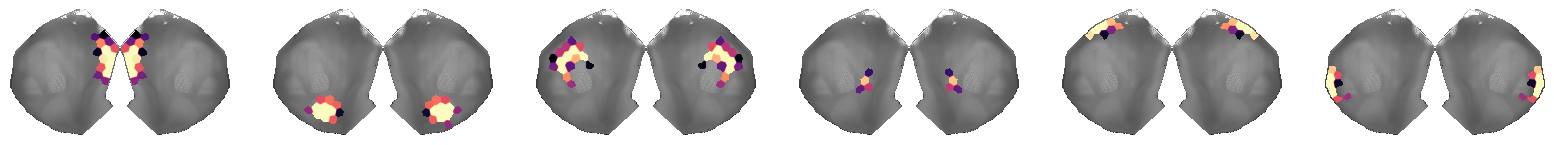

In [5]:
_ = bs.show(pi_fuse, vmin=0.2, vmax=1, mask_thresh=0.2, proj='flat', contour=False)

### Extract all keys

In [6]:
keys = []
for f in os.listdir(mice.cfg.svinet_dir):
    if f"n-{mice.cfg.nn}*{mice.cfg.ll}" not in f:
        continue
    key = f.split('_')
    try:
        i = next(
            i for i, e in
            enumerate(key)
            if 'sub' in e
        )
    except StopIteration:
        continue
    keys.append('_'.join(key[i:]))
keys = sorted(keys)
len(keys)

547

## SVINET

In [7]:
kwargs = {
    'mice': mice,
    'num_k': None,
    'perc': 'p10-sample',
    'mode': 'bold',
    'verbpose': True,
}

### Fit all (once)

In [8]:
from tqdm import tqdm

In [9]:
%%time

for num_k in [2, 3, 5, 7, 10]:
    kwargs['num_k'] = num_k
    for key in tqdm(keys):
        sv = SVINET(key=key, **kwargs)
        sv.pi_fuse = pi_fuse
        _ = sv.load_runs().fit_svinet()

100%|██████████| 547/547 [7:01:04<00:00, 46.19s/it]  

CPU times: user 3d 56min 31s, sys: 2h 14min 11s, total: 3d 3h 10min 43s
Wall time: 1d 2h 26min 49s
